Installing files
environment name: singecell

Application of MOFA (combines different types of omics data to find latent factors that explains variance in the data) to a multi-omics data set

In [1]:
import sys
print(f"Python path: {sys.executable}")


Python path: c:\Users\chuab\anaconda3\envs\singlecell\python.exe


In [2]:
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import muon as mu
import mofax as mofa
import seaborn as sns

# Optional: Apply the legend fix in-code if you didn't downgrade matplotlib
import matplotlib.legend as mlegend
if not hasattr(mlegend.Legend, "legendHandles"):
    mlegend.Legend.legendHandles = property(lambda self: self.legend_handles)

print("="*30)
print("✅ Environment setup complete!")
print(f"NumPy:   {np.__version__}")
print(f"Scanpy:  {sc.__version__}")
print(f"Muon:    {mu.__version__}")
print("="*30)


c:\Users\chuab\anaconda3\envs\singlecell\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Environment setup complete!
NumPy:   1.24.4
Scanpy:  1.9.3
Muon:    0.1.6


Load Data

In [3]:
import pandas as pd
import scanpy as sc
from pathlib import Path

# 1. Use Pathlib for safe path handling (no trailing slash needed)
data_dir = Path(r"C:\Users\chuab\Desktop\Hackathon\Introductory_lectures\(5) Models_for_multimodal_data_integration\Integrative_Modal_data")

# 2. Create the dictionary of AnnData objects
# Using data_dir / f"{i}.csv" safely adds the correct backslash
mods = {
    i: sc.AnnData(pd.read_csv(data_dir / f"{i}.csv", index_col=0).T)
    for i in ("mRNA", "methylation", "mutations", "drugs")
}

# 3. Display info about each modality to confirm success
for name, adata in mods.items():
    print(f"Modality: {name:12} | Cells: {adata.n_obs:5} | Features: {adata.n_vars:5}")

mods


Modality: mRNA         | Cells:   200 | Features:  5000
Modality: methylation  | Cells:   200 | Features:  4248
Modality: mutations    | Cells:   200 | Features:    69
Modality: drugs        | Cells:   200 | Features:   310


{'mRNA': AnnData object with n_obs × n_vars = 200 × 5000,
 'methylation': AnnData object with n_obs × n_vars = 200 × 4248,
 'mutations': AnnData object with n_obs × n_vars = 200 × 69,
 'drugs': AnnData object with n_obs × n_vars = 200 × 310}

input data of the mRNA modality

In [4]:
print("First sample names: ", mods['mRNA'].obs_names[0:5].tolist())
print("First gene names: ", mods['mRNA'].var_names[0:5].tolist())
print("Values: ", mods['mRNA'].X[0:5, 0:5])
print("Mean: ", np.mean(mods['mRNA'].X[[0]]), ", Variance: ", np.var(mods['mRNA'].X[[0]]))

First sample names:  ['H045', 'H109', 'H024', 'H056', 'H079']
First gene names:  ['ENSG00000244734', 'ENSG00000158528', 'ENSG00000198478', 'ENSG00000175445', 'ENSG00000174469']
Values:  [[ 4.55864355 11.74185387  8.92145552 12.6864583   2.6449457 ]
 [ 2.72151227 13.28743173  2.72151227 10.92598507 12.64835536]
 [ 9.9384557   2.34100585 12.38145198  1.52884845  1.52884845]
 [13.27800449  3.23287407  8.10626625  1.52884845 13.56521029]
 [ 6.08687386 11.94081968  4.88950293 13.34058824  5.47691374]]
Mean:  6.18622345321868 , Variance:  12.791719513892316


The likelihood distribution for this data is Negative Bionomial distribuition as the variance exceeds the mean.

input data of the methylation modality

In [5]:
print("First sample names: ", mods['methylation'].obs_names[0:5].tolist())
print("First gene names: ", mods['methylation'].var_names[0:5].tolist())
print("Values: ", mods['methylation'].X[0:5, 0:5])
print("Mean: ", np.mean(mods['methylation'].X[[0]]), ", Variance: ", np.var(mods['methylation'].X[[0]]))

First sample names:  ['H045', 'H109', 'H024', 'H056', 'H079']
First gene names:  ['cg10146935', 'cg26837773', 'cg17801765', 'cg13244315', 'cg06181703']
Values:  [[ 1.81108585 -5.17257225  5.41152631 -0.11882508  5.12038376]
 [-3.99750846  1.59487016  5.41269253  1.04387064  1.27948028]
 [-2.84431298  0.16117049  0.36570594 -4.21923622  0.7211004 ]
 [-3.33865611 -2.09343256  0.37363417 -1.59219648  4.04705939]
 [-0.01936203  3.74897956  5.41200957  1.41641834  5.23742246]]
Mean:  -0.12252896876933968 , Variance:  10.734564445711086


The likelihood distribution for this data is Gaussian distribuition as the mean is near zero, and the variance suggests that the data is well-behaved, fitting the assumptions of a Gaussian distribution.

Input data of the mutations modality

In [6]:
print("First sample names: ", mods['mutations'].obs_names[0:5].tolist())
print("First gene names: ", mods['mutations'].var_names[0:5].tolist())
print("Values: ", mods['mutations'].X[0:5, 0:5])
print("Mean: ", np.mean(mods['mutations'].X[[0]]), ", Variance: ", np.var(mods['mutations'].X[[0]]))

First sample names:  ['H045', 'H109', 'H024', 'H056', 'H079']
First gene names:  ['gain2p25.3', 'gain3q26', 'del6p21.2', 'del6q21', 'del8p12']
Values:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Mean:  nan , Variance:  nan


The likelihood distribution for this data is Bernoulli distribuition as the data models binary data.

input data of the mutations modality

In [7]:
print("First sample names: ", mods['drugs'].obs_names[0:5].tolist())
print("First gene names: ", mods['drugs'].var_names[0:5].tolist())
print("Values: ", mods['drugs'].X[0:5, 0:5])
print("Mean: ", np.mean(mods['drugs'].X[[0]]), ", Variance: ", np.var(mods['drugs'].X[[0]]))

First sample names:  ['H045', 'H109', 'H024', 'H056', 'H079']
First gene names:  ['D_001_1', 'D_001_2', 'D_001_3', 'D_001_4', 'D_001_5']
Values:  [[0.02363938 0.04623274 0.31874706 0.82370272 0.89627769]
 [0.073599   0.10623002 0.2732891  0.71713794 0.88500034]
 [       nan        nan        nan        nan        nan]
 [0.0581393  0.09022028 0.23221452 0.72257364 0.79574966]
 [0.02042077 0.04750543 0.36389622 0.80739074 0.87948865]]
Mean:  0.573514613623617 , Variance:  0.1476769632454062


The likelihood distribution for this data is Beta distribuition as the data models variables that are constrained between 0 and 1

creating a data frame


In [8]:
# load meta data information
CLL_metadata = pd.read_csv("ftp://ftp.ebi.ac.uk/pub/databases/mofa/cll_vignette/sample_metadata.txt",
                           sep="\t", index_col="sample")
CLL_metadata.head()

#To create a multi-modal data object from the dictionary containing the four single modalities, we use the package muon. muon allows to directly run MOFA on this MuData object.
mdata = mu.MuData(mods)
# add metadata
mdata.obs = mdata.obs.join(CLL_metadata)
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
  4 modalities
    mRNA:	200 x 5000
    methylation:	200 x 4248
    mutations:	200 x 69
    drugs:	200 x 310

Integrate data

In [9]:
mu.tl.mofa(mdata, use_obs='union',
           n_factors=15, convergence_mode='medium',
           outfile="models/CLL.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
         


Loaded view='mRNA' group='group1' with N=200 samples and D=5000 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the factors:

Interpret intergrated data

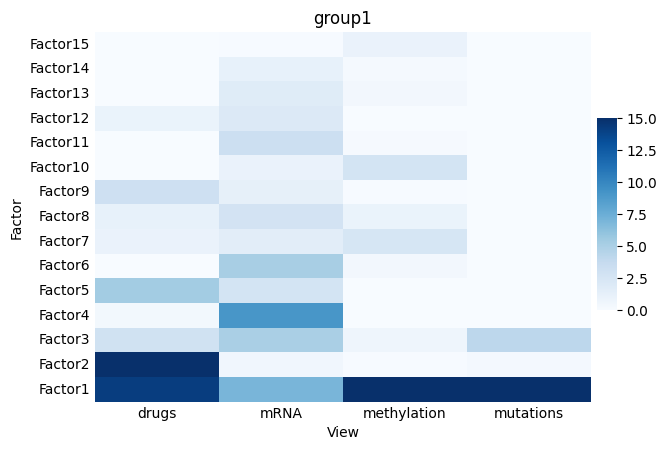

In [10]:
# load trained MOFA model
model = mofa.mofa_model("models/CLL.hdf5")
model
# variance decomposition
mofa.plot_r2(model, x='View', vmax=15)

MOFA model using only 5 factors

In [11]:
# Train a new MOFA model with only 5 factors
mu.tl.mofa(mdata, use_obs='union',
           n_factors=5, convergence_mode='medium',
           outfile="models/CLL_5factors.hdf5")

# Load the new MOFA model
model_5factors = mofa.mofa_model("models/CLL_5factors.hdf5")

# Get the variance explained for the original model
r2_original = model.get_r2()

# Get the variance explained for the new model with 5 factors
r2_5factors = model_5factors.get_r2()

# Compare the variance explained per view between the two models
print("Variance explained per view (original model):")
print(r2_original)

print("\nVariance explained per view (5 factors model):")
print(r2_5factors)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
         


Loaded view='mRNA' group='group1' with N=200 samples and D=5000 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the factors:

comparing how much variance is explained by the original model versus the new model (with 5 factors) for each view (e.g., mRNA, methylation, mutations, etc.)

Plot samples (Factor 1 and 2)

<Axes: title={'center': 'Gender'}, xlabel='Factor1', ylabel='Factor2'>

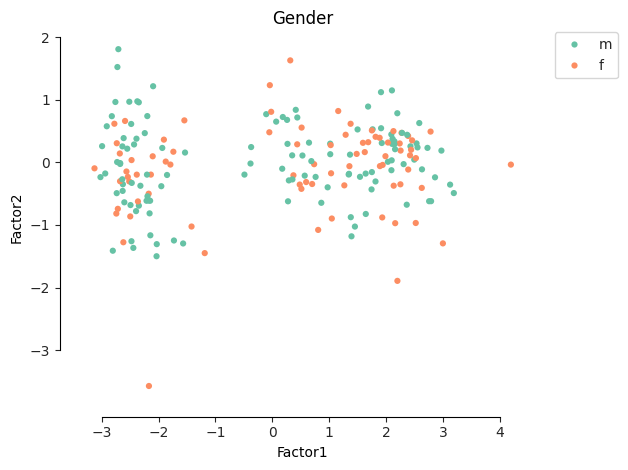

In [12]:
# Plotting the samples in the learned factor space
mofa.plot_factors(model, x = "Factor1", y="Factor2",  size=20, color = "Gender")

(Exercise) Plot samples (Factor 3 and 4)

<Axes: title={'center': 'Gender'}, xlabel='Factor3', ylabel='Factor4'>

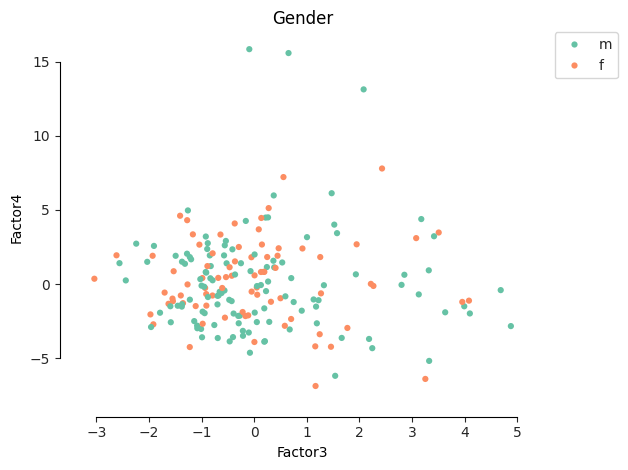

In [13]:
# Plotting the samples in the learned factor space
mofa.plot_factors(model, x = "Factor3", y="Factor4",  size=20, color = "Gender")

Factor 1 analysis

<Axes: title={'center': 'IGHV'}, xlabel='Factor1', ylabel='Factor2'>

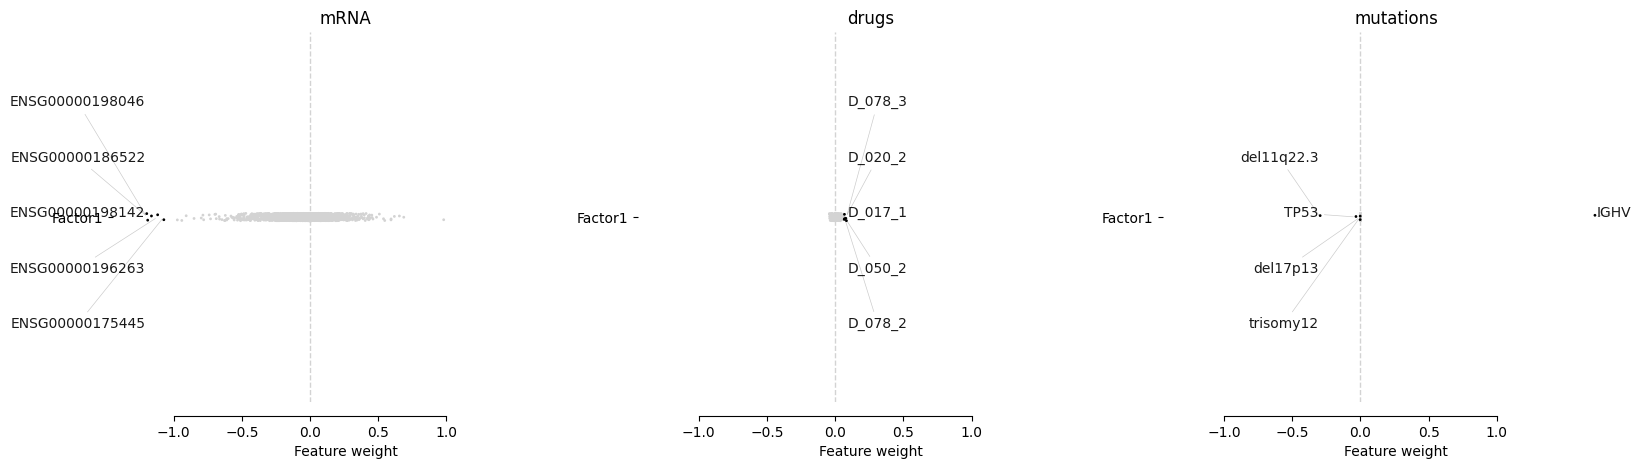

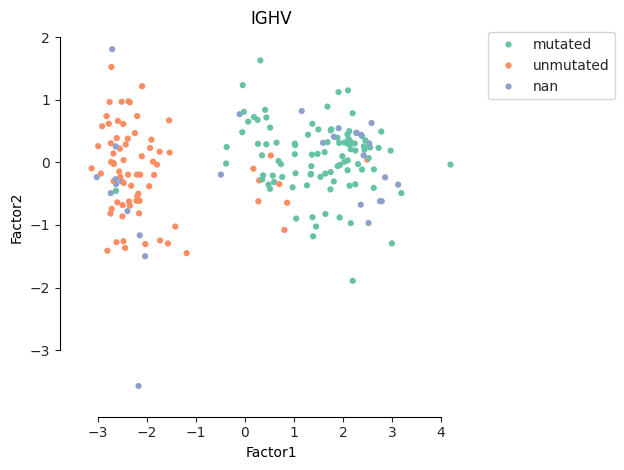

In [14]:
mofa.plot_weights(model, views=['mRNA', 'mutations', 'drugs'], factors=0, zero_line=True, ncols=3, label_size=10);
# Coloring the samples according to IGHV status
model.metadata.IGHV = (
    model.metadata.IGHV.astype(str).
        replace({'1.0': 'mutated', '0.0': 'unmutated'}).
        astype('category').cat.reorder_categories(["mutated", "unmutated", "nan"])
)

mofa.plot_factors(model, x = "Factor1", y="Factor2",  size=20, color = "IGHV")

The code plots the weights for Factor 0 across mRNA, mutations, and drugs, and then creates a scatter plot of Factor 1 vs Factor 2 with sample points colored by IGHV status (mutated, unmutated, or nan).

(Exercise) Factor 3 analysis

Weights for Factor 3 across modalities (factors=2):
[[-6.61105254e-02]
 [ 2.23701470e-03]
 [-3.40459432e-01]
 ...
 [ 2.76044246e-04]
 [ 2.05145207e-04]
 [-1.35393740e-03]]


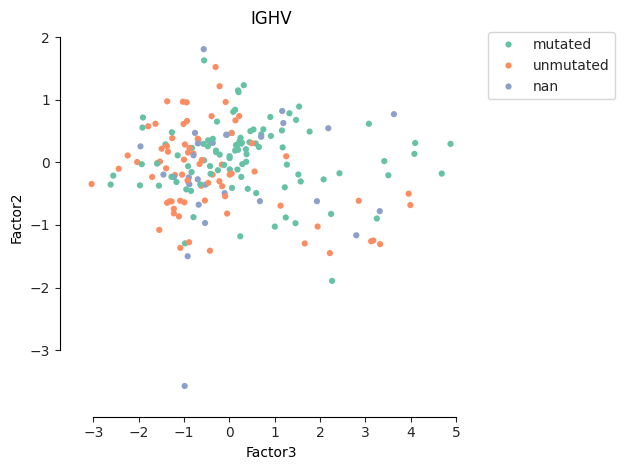

In [15]:
# Coloring the samples according to IGHV status for Factor 3
model.metadata.IGHV = (
    model.metadata.IGHV.astype(str).
        replace({'1.0': 'mutated', '0.0': 'unmutated'}).
        astype('category').cat.reorder_categories(["mutated", "unmutated", "nan"])
)

# Plot Factor 3 against another factor (e.g., Factor 2) with IGHV coloring
mofa.plot_factors(model, x="Factor3", y="Factor2", size=20, color="IGHV")

# Extract weights for Factor 3 using factors=2 (since counting starts at 0)
weights_factor3 = model.get_weights(factors=2)  # factors=2 for Factor 3

# Explore the weights in the different modalities for Factor 3
print("Weights for Factor 3 across modalities (factors=2):")
print(weights_factor3)

Color samples by IGHV status, plot Factor 3 against Factor 2 with IGHV coloring, and extract and examine the weights for Factor 3 across data types.

Combination of factors

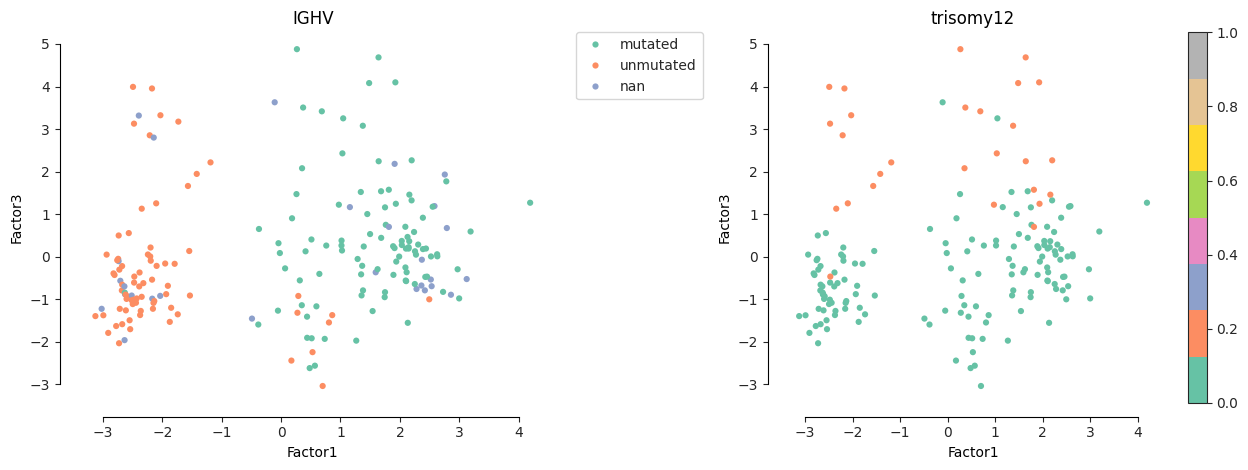

In [16]:
mofa.plot_factors(model, x=0, y=2, color=["IGHV", "trisomy12"], size=20,  palette="Set2");

Application of MEFISTO (uncover latent variables that exxplains shaared variance across multiple data modalities) to a longitudinal data set

Load Evodevo data

In [17]:
data = pd.read_csv("C:/Users/chuab/OneDrive - Universität Heidelberg/Desktop/Hackathon/Week 1 exercise/data/evodevo.csv", sep=",", index_col=0)
data

,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


Load Brain data

In [18]:
brain = data[data.view == 'Brain'].pivot(index='sample', columns='feature', values='value')
brain
# Create dictionary of AnnData objects per view
views = data.view.unique()
data_list = [data[data.view == m].pivot(index='sample', columns='feature', values='value') for m in views]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods
# Metadata: stores time and group (= species) information for each sample
obs = (
    data[['sample', 'time', 'group']]
        .drop_duplicates()
        .rename(columns = {'group' : 'species'})
        .set_index('sample')
)
obs
# Create mudata object
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

Integrate data

In [19]:
mu.tl.mofa(mdata, n_factors=5,
           groups_label="species",
           smooth_covariate='time', smooth_warping=True,
           smooth_kwargs={"warping_ref": "Mouse", "new_values": list(range(1, 15))},
           outfile="models/mefisto.hdf5",
           n_iterations=25)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
         


Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' group='Opossum' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rabbit' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rat' with N=16 samples and D=7696 features...
Loaded view=

Visualization in the factor space

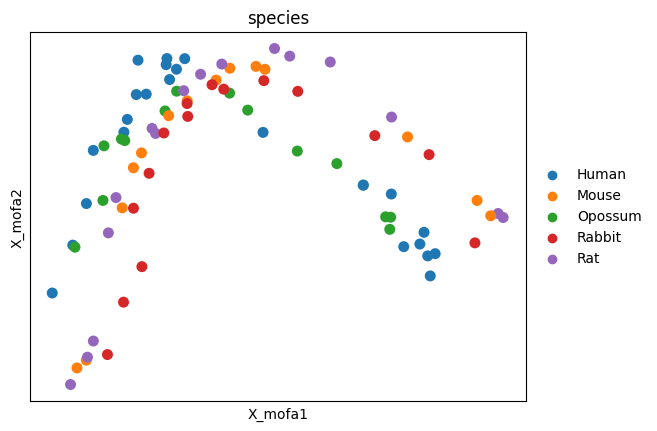

In [20]:
mu.pl.mofa(mdata, color="species", size = 250)

Colorisation of MEFISTO plot

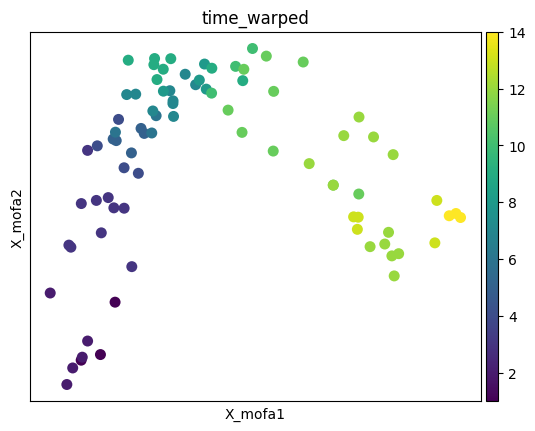

In [21]:
mu.pl.mofa(mdata, color="time_warped", size = 250)

Alignment of plot

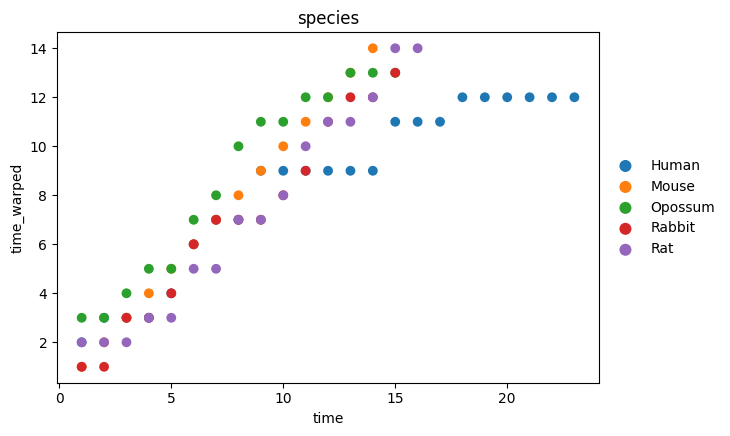

In [22]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import mofax as mofa
import seaborn as sns
sc.pl.scatter(mdata, x="time", y="time_warped", color="species", size=200)

Latent factors versus common developmental time

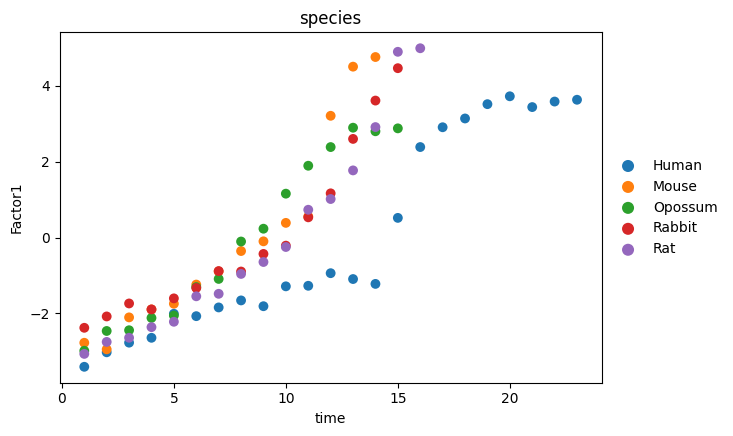

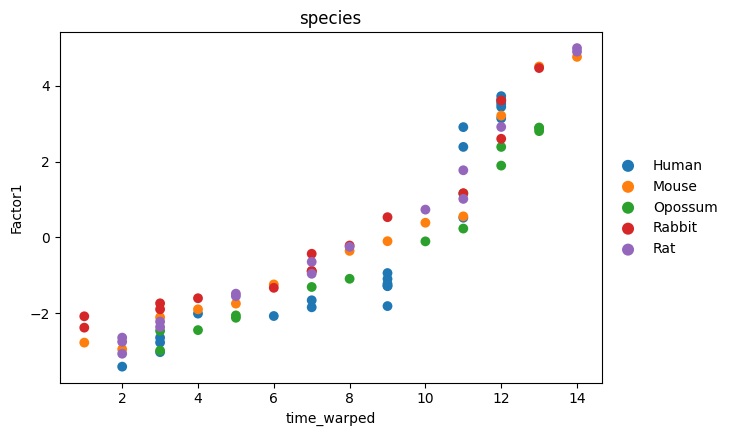

In [23]:
mdata.obs["Factor1"] = mdata.obsm["X_mofa"][:,0]
sc.pl.scatter(mdata, x="time", y="Factor1", color="species", size=200)
# after alignment
sc.pl.scatter(mdata, x="time_warped", y="Factor1", color="species", size=200)

Adds Factor 1 from the MOFA model to the data, then plots scatter plots of "time" vs. "Factor1" and "time_warped" vs. "Factor1," colored by species and sized by value, to show how the alignment affects the factor distribution.

Further analyses (Interpolation)

In [24]:
model = mofa.mofa_model("models/mefisto.hdf5")
model

MOFA+ model: mefisto
Samples (cells): 83
Features: 38480
Groups: Human (23), Mouse (14), Opossum (15), Rabbit (15), Rat (16)
Views: Brain (7696), Cerebellum (7696), Heart (7696), Liver (7696), Testis (7696)
Factors: 5
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 14 new values

Interpolation

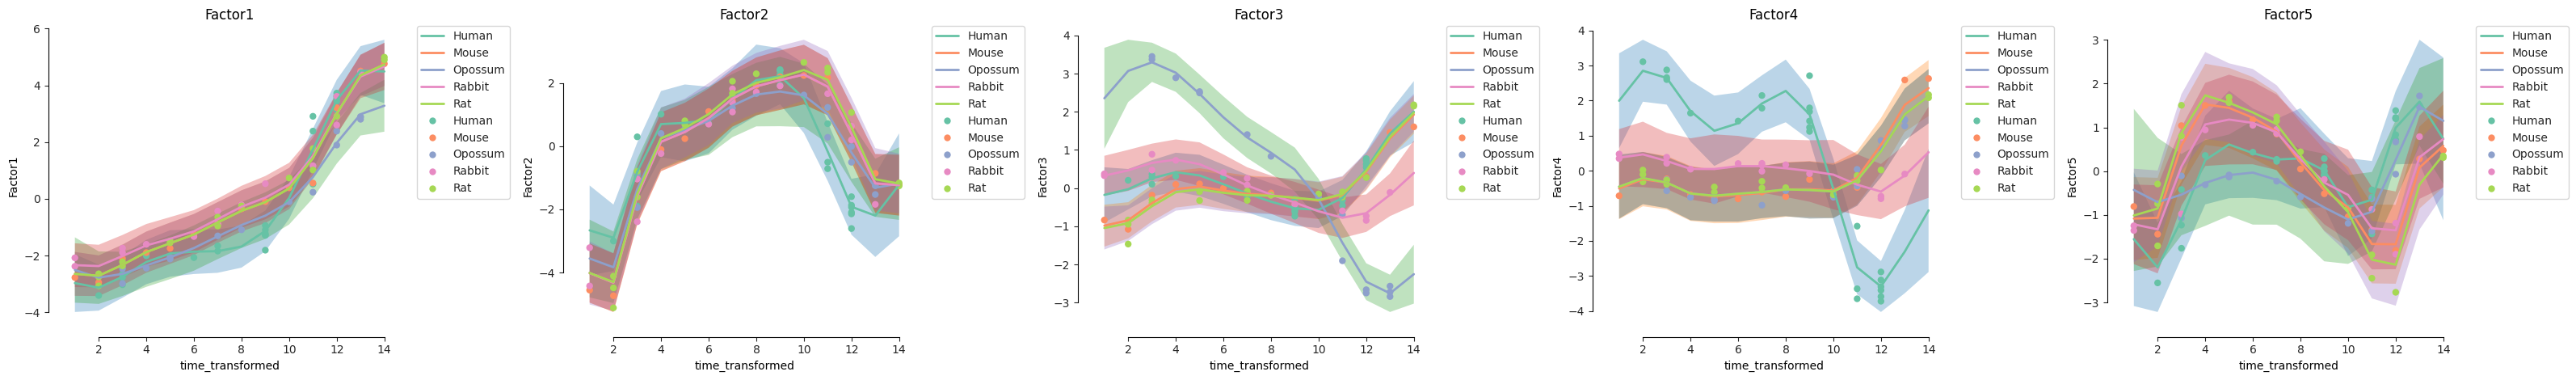

In [25]:
mofa.plot_interpolated_factors(model, factors=range(model.nfactors),
                                ncols=5, size=70);

Further analyses (Smoothness and sharedness of factors)

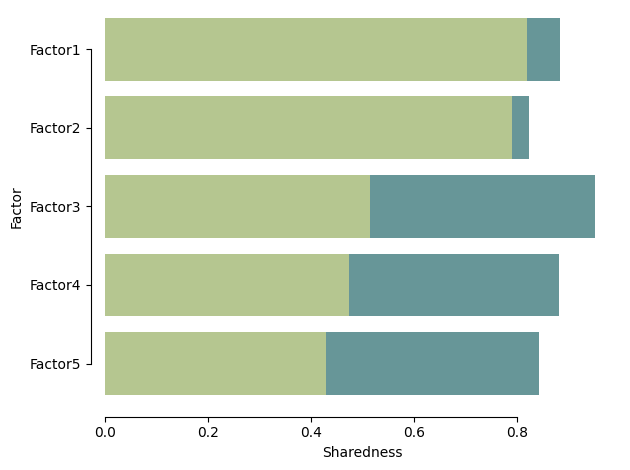

In [26]:
mofa.plot_smoothness(model);
mofa.plot_sharedness(model);

Advanced exercise: using pyro to built your own factor model ( built our own Bayesian matrix factorization model to understand how a factor model can be trained using stochastic variational inference)

In [38]:
# Required packages
import pyro
from pyro.nn import PyroSample, PyroModule
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# simulate data
n_obs = 100
n_features = 20
n_factors = 5

torch.manual_seed(2024)
Z_in = torch.randn(n_obs, n_factors)
W_in = torch.randn(n_features, n_factors)

# create observated values from the simulated factor and weight matrix with some random noise
Y = torch.matmul(Z_in, W_in.t()) + 0.2 * torch.randn(n_obs, n_features)
print(Y.shape)
print(Y)

torch.Size([100, 20])
tensor([[ 5.3621e-01, -9.5076e-01, -8.2234e-01,  ..., -2.3100e+00,
          1.5223e+00,  4.2384e-01],
        [-8.2410e-01, -2.6438e+00,  5.0057e-01,  ..., -1.6188e+00,
          1.4766e+00, -1.3624e+00],
        [ 3.5991e+00,  8.5626e+00, -1.4502e+00,  ...,  9.4482e-01,
         -1.3726e+00,  1.0173e+00],
        ...,
        [-7.1978e-01, -2.0009e+00,  1.3592e-01,  ..., -6.8602e-01,
          6.1233e-01,  4.7834e-02],
        [-8.2973e-04, -2.9130e+00,  4.6990e-01,  ..., -9.3622e-01,
          9.6277e-02,  7.1257e-01],
        [-9.2778e-01,  2.7502e+00, -1.1326e+00,  ...,  5.6296e+00,
         -1.5591e+00,  2.7615e+00]])


Training a factor model with 5 latent factors:

In [54]:
class FA(PyroModule):
    def __init__(self, Y, K):
        super().__init__()
        self.Y = Y.float() if isinstance(Y, torch.Tensor) else torch.tensor(Y).float()
        self.K = K
        self.num_samples, self.num_features = self.Y.shape
        
        self.mask = ~torch.isnan(self.Y)
        self.Y_filled = torch.nan_to_num(self.Y, nan=0.0)

        # Weight matrix (K x Features)
        self.W = PyroSample(dist.Normal(torch.zeros(self.K, self.num_features), 
                                        torch.ones(self.K, self.num_features)).to_event(2))
        # Latent Factors (Samples x K)
        self.Z = PyroSample(dist.Normal(torch.zeros(self.num_samples, self.K), 
                                        torch.ones(self.num_samples, self.K)).to_event(2))

    def forward(self, Y=None):
        W = self.W
        Z = self.Z
        mu = torch.matmul(Z, W) # Result is [100, 10]
        
        # Use nested plates to allow the [100, 10] mask to map to individual entries
        with pyro.plate("samples", self.num_samples, dim=-2):
            with pyro.plate("features", self.num_features, dim=-1):
                pyro.sample("obs", dist.Normal(mu, 0.1).mask(self.mask), obs=self.Y_filled)
            
    def train(self, num_iterations=1000):
        guide = autoguide.AutoDiagonalNormal(self)
        optimizer = pyro.optim.Adam({"lr": 0.01})
        
        # Using the requested name
        svi = SVI(self, guide, optimizer, loss=Trace_ELBO())

        pyro.clear_param_store()
        losses = []
        for i in range(num_iterations):
            loss = svi.step()
            losses.append(loss)
            if i % 100 == 0:
                print(f"Iteration {i}: loss = {loss:.4f}")

        map_estimates = guide()
        return losses, {k: v.detach() for k, v in map_estimates.items()}


Iteration 0: loss = 217879.7157
Iteration 100: loss = 29118.7250
Iteration 200: loss = 6449.0957
Iteration 300: loss = 2541.5436
Iteration 400: loss = 1607.9099
Iteration 500: loss = 1262.2423
Iteration 600: loss = 1207.4648
Iteration 700: loss = 1192.1232
Iteration 800: loss = 1300.2477
Iteration 900: loss = 1144.9835


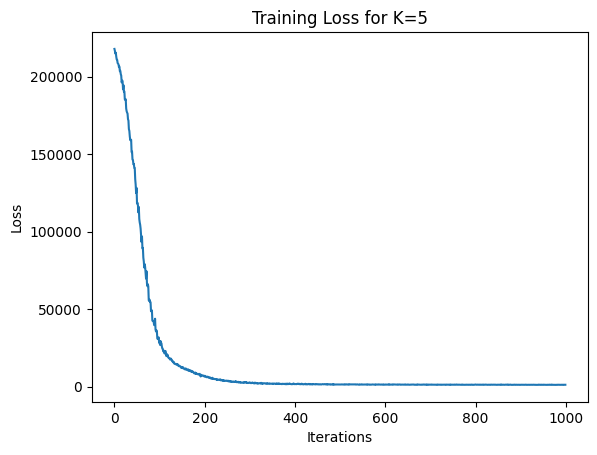

Mean Squared Error for K=5: 0.014321517199277878


In [55]:
import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt

# Simulating data Y with 5 latent factors and some random noise
num_samples = 100
num_features = 10
K = 5

# Simulate the data
W_true = torch.randn(num_features, K)  # Weight matrix
Z_true = torch.randn(num_samples, K)  # Latent factors matrix
Y_sim = torch.matmul(Z_true, W_true.t()) + torch.randn(num_samples, num_features) * 0.1  # Add noise

# Initialize FA model with K=5 latent factors
fa_model = FA(Y_sim, K=5)

# Train the model
train_loss, map_estimates = fa_model.train()

# Plotting the training loss over iterations
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss for K=5')
plt.show()

# Compute the estimated Y_hat using the MAP estimates
W_est = map_estimates["W"]
Z_est = map_estimates["Z"]
Y_hat = torch.matmul(Z_est, W_est)

# Calculate Mean Squared Error (MSE) between Y and Y_hat
mse = torch.mean((Y_sim - Y_hat) ** 2)
print(f"Mean Squared Error for K=5: {mse.item()}")


Identifying the number of latent factors in the data

Iteration 0: loss = 216999.0499
Iteration 100: loss = 112595.6825
Iteration 200: loss = 76895.2509
Iteration 300: loss = 59726.5403
Iteration 400: loss = 44418.2705
Iteration 500: loss = 42860.3362
Iteration 600: loss = 42894.4259
Iteration 700: loss = 42675.4936
Iteration 800: loss = 42594.1683
Iteration 900: loss = 42599.8968
Mean Squared Error for K=2: 0.861537754535675
Iteration 0: loss = 219598.0972
Iteration 100: loss = 71864.6678
Iteration 200: loss = 20981.0456
Iteration 300: loss = 15150.9846
Iteration 400: loss = 14773.9640
Iteration 500: loss = 14645.7026
Iteration 600: loss = 14571.1165
Iteration 700: loss = 14411.6065
Iteration 800: loss = 14477.4691
Iteration 900: loss = 14397.4907
Mean Squared Error for K=3: 0.2924020290374756
Iteration 0: loss = 217301.3416
Iteration 100: loss = 57627.2548
Iteration 200: loss = 11479.7360
Iteration 300: loss = 6995.9439
Iteration 400: loss = 6604.8694
Iteration 500: loss = 6496.4358
Iteration 600: loss = 6441.8643
Iteration 700: loss = 

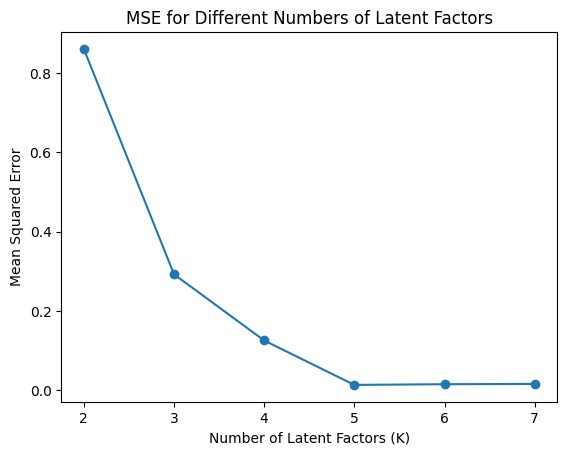

In [56]:
K_values = [2, 3, 4, 5, 6, 7]
mse_values = []

# Train factor models with different numbers of latent factors
for K in K_values:
    fa_model = FA(Y_sim, K=K)
    _, map_estimates = fa_model.train()

    W_est = map_estimates["W"]
    Z_est = map_estimates["Z"]
    Y_hat = torch.matmul(Z_est, W_est)
    
    mse = torch.mean((Y_sim - Y_hat) ** 2)
    mse_values.append(mse.item())
    print(f"Mean Squared Error for K={K}: {mse.item()}")

# Plot MSE over different values of K
plt.plot(K_values, mse_values, marker='o')
plt.xlabel('Number of Latent Factors (K)')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Numbers of Latent Factors')
plt.show()


 Missing values in the observations

Iteration 0: loss = 219760.4177
Iteration 100: loss = 30830.8804
Iteration 200: loss = 8615.5092
Iteration 300: loss = 2274.8353
Iteration 400: loss = 1540.3580
Iteration 500: loss = 1394.3145
Iteration 600: loss = 1156.4359
Iteration 700: loss = 1160.6071
Iteration 800: loss = 1272.9834
Iteration 900: loss = 1172.8241
Mean Squared Error for 1% missing: 0.013692031614482403
Iteration 0: loss = 210280.1533
Iteration 100: loss = 30233.5594
Iteration 200: loss = 6395.0670
Iteration 300: loss = 2535.0218
Iteration 400: loss = 1541.9391
Iteration 500: loss = 1412.4168
Iteration 600: loss = 1224.5154
Iteration 700: loss = 1247.1056
Iteration 800: loss = 1176.0049
Iteration 900: loss = 1123.0957
Mean Squared Error for 2.5% missing: 0.015157409943640232
Iteration 0: loss = 212835.1261
Iteration 100: loss = 28066.4744
Iteration 200: loss = 8469.4451
Iteration 300: loss = 3315.1160
Iteration 400: loss = 1793.2265
Iteration 500: loss = 1446.9771
Iteration 600: loss = 1246.8707
Iteration 700: loss

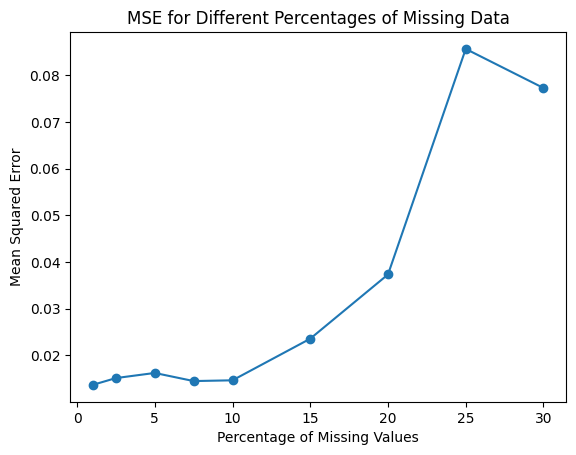

In [58]:
# Create missing data by setting entries to NaN
missing_percentages = [1, 2.5, 5, 7.5, 10, 15, 20, 25, 30]
mse_missing_values = []

# Function to create missing data
def create_missing_data(Y, missing_percentage):
    total_entries = Y.numel()
    num_missing = int(total_entries * missing_percentage / 100)
    missing_indices = torch.randperm(total_entries)[:num_missing]
    Y_missing = Y.clone()
    Y_missing.view(-1)[missing_indices] = float('nan')  # Set selected entries to NaN
    return Y_missing

# Train factor models with different percentages of missing data
for missing_percentage in missing_percentages:
    Y_missing = create_missing_data(Y_sim, missing_percentage)
    fa_model = FA(Y_missing, K=5)
    _, map_estimates = fa_model.train()

    W_est = map_estimates["W"]
    Z_est = map_estimates["Z"]
    Y_hat = torch.matmul(Z_est, W_est) 

    mse = torch.mean((Y_sim - Y_hat) ** 2)
    mse_missing_values.append(mse.item())
    print(f"Mean Squared Error for {missing_percentage}% missing: {mse.item()}")

# Plot MSE over missing data percentages
plt.plot(missing_percentages, mse_missing_values, marker='o')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Percentages of Missing Data')
plt.show()
